In [147]:
import healpy as hp
import numpy as np
import h5py, os

from astropy.io import fits
from functools import reduce

%load_ext autoreload
%autoreload 2
from msfm.utils import analysis
from msfm.utils.analysis import load_pixel_file
from msfm.utils.maps import map_to_data_vec, data_vec_to_map

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In this notebook, the `.h5` file containing the correct pixel indices for all of the masks used in the project are generated

Based off [KiDS_1000_index_file.ipynb](https://cosmo-gitlab.phys.ethz.ch/jafluri/arne_handover/-/blob/main/carpet/notebooks/KiDS_1000_index_file.ipynb) by Janis Fluri.

### global constants

In [148]:
conf = analysis.load_config()

n_side = conf["analysis"]["n_side"]
n_pix = conf["analysis"]["n_pix"]

n_side_down = conf["analysis"]["n_side_down"]

pixels_dir = f"../../data/DESY3_pixels_{n_side}.h5"

23-04-19 16:12:25  analysis.py INF   Loaded the config 


# Transformations

### Rotations

In [149]:
# these are the standard rotation matrices

def get_rot_x(ang):
    return np.array([[1.0, 0.0,         0.0],
                     [0.0, np.cos(ang), -np.sin(ang)],
                     [0.0, np.sin(ang), np.cos(ang)]]).T # Inverse because of healpy

def get_rot_y(ang):
    return np.array([[np.cos(ang),  0.0, np.sin(ang)],
                     [0.0,          1.0, 0.0],
                     [-np.sin(ang), 0.0, np.cos(ang)]]).T # Inverse because of healpy

def get_rot_z(ang):
    return np.array([[np.cos(ang), -np.sin(ang), 0.0],
                     [np.sin(ang), np.cos(ang),  0.0],
                     [0.0,         0.0,          1.0]]).T # Inverse because of healpy

In [150]:
# these rotation angles were found by trial and error and don't preserve the number and arrangement of pixels
y_rot = get_rot_y(-0.125)
z_rot = get_rot_z(-1.22)

### HEALPix Symmetry transformations

In [151]:
# mirror (up down)
def mirror_pix(pix, nside=n_side, lr=False):
    theta, phi = hp.pix2ang(ipix=pix, nside=n_side)
    if lr:
        phi = 2*np.pi - phi
    else:
        theta = np.pi - theta
    new_pix = hp.ang2pix(theta=theta, phi=phi, nside=nside)

    # make sure that no pixel appears twice that should not
    assert len(set(new_pix)) == len(set(pix))

    return new_pix

# 90 degree rotations
def rotate_pix(pix, n_rot=1, nside=n_side):
    theta, phi = hp.pix2ang(ipix=pix, nside=nside)
    phi = (phi + n_rot*np.pi/2) % (2*np.pi)
    new_pix = hp.ang2pix(theta=theta, phi=phi, nside=nside)

    # make sure that no pixel appears twice that should not
    assert len(set(new_pix)) == len(set(pix))
    
    return new_pix

# Metacal

In [152]:
# exclude the 0th bin, which includes all of the others
tomo_inds = [1, 2, 3, 4]
z_lims = conf["survey"]["metacal"]["z_lims"]
z_bins = conf["survey"]["metacal"]["z_bins"]

### load Metacal catalog

In [153]:
# data given by Dominik
data_dir = '/Users/arne/data/DESY3/DES_Y3KP_NGSF/'

pix_list = []
vec_list = []
# consider all tomographic bins
for tomo in tomo_inds:
    # J2000 angles in degrees
    alpha = h5py.File(os.path.join(data_dir, f'ALPHAWIN_J2000_tomo={tomo}.h5'))['ALPHAWIN_J2000'][:]
    delta = h5py.File(os.path.join(data_dir, f'DELTAWIN_J2000_tomo={tomo}.h5'))['DELTAWIN_J2000'][:]

    # angles like in healpy in radian
    theta = -np.deg2rad(delta) + np.pi/2
    phi = np.deg2rad(alpha)

    # derived pixel ids, shape (num_galaxies,)
    pix = hp.ang2pix(nside=n_side, theta=theta, phi=phi)

    # vector positions of the galaxies, shape (num_galaxies, 3)
    vec = hp.ang2vec(theta=theta, phi=phi)

    pix_list.append(pix)
    vec_list.append(vec)

### original masks


bin desy3metacal1
n_gal = 24940465
n_pix = 370313

bin desy3metacal2
n_gal = 25280405
n_pix = 370333

bin desy3metacal3
n_gal = 24891859
n_pix = 370322

bin desy3metacal4
n_gal = 25091297
n_pix = 370091


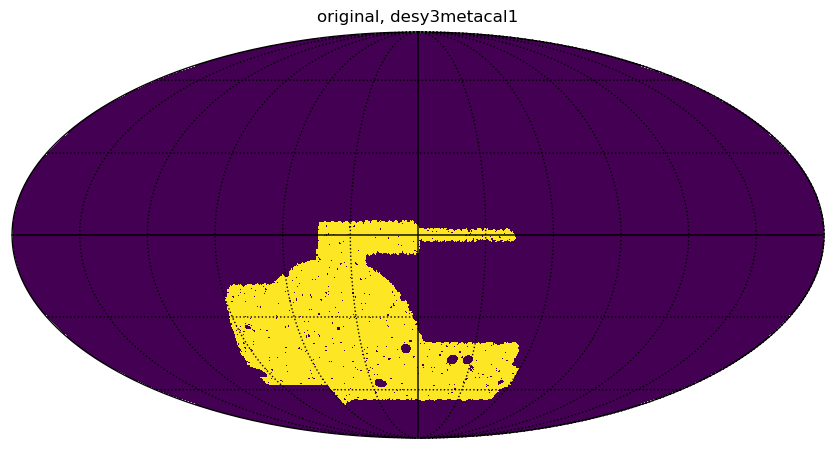

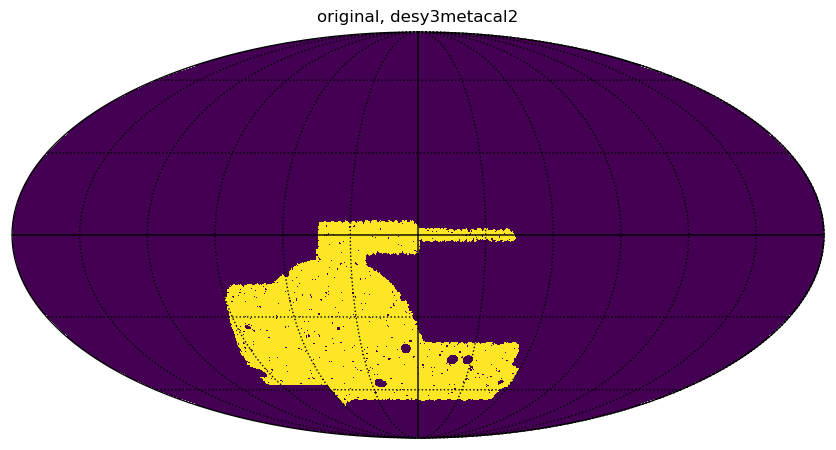

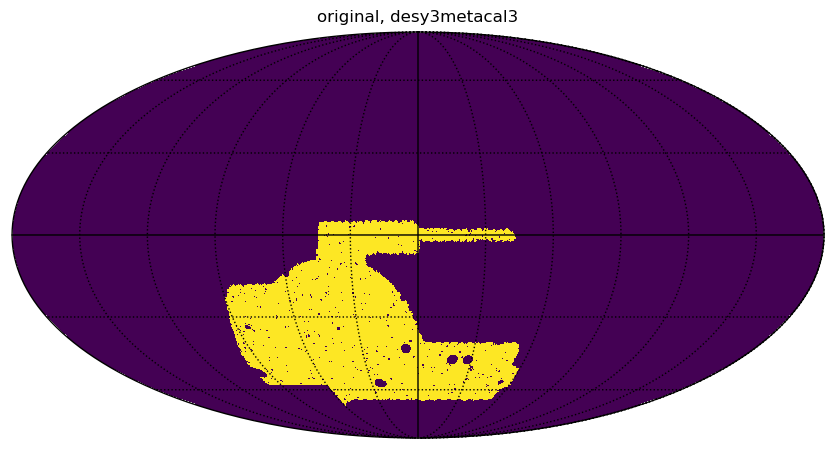

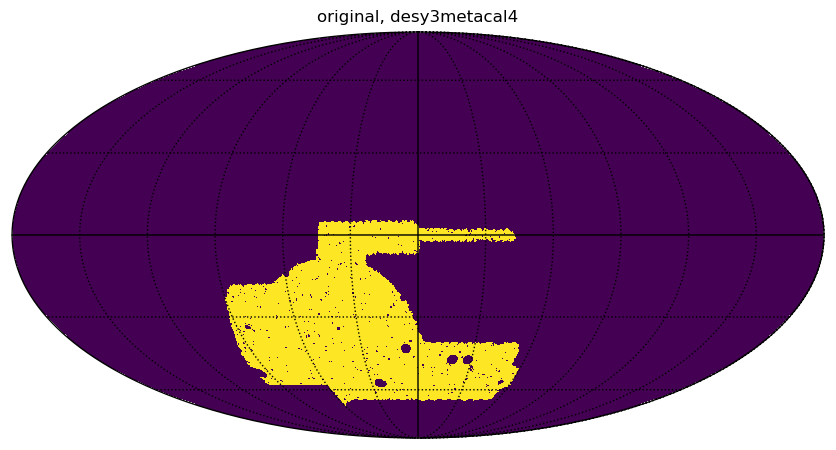

In [154]:
for pix, z_bin in zip(pix_list, z_bins):
    print(f"\nbin {z_bin}")

    z_mask = np.zeros(n_pix)
    z_mask[pix] = 1
    hp.mollview(z_mask, title=f"original, {z_bin}", cbar=False)
    hp.graticule()

    print(f"n_gal = {len(pix)}")
    print(f"n_pix = {np.sum(z_mask, dtype=int)}")

### rotated masks

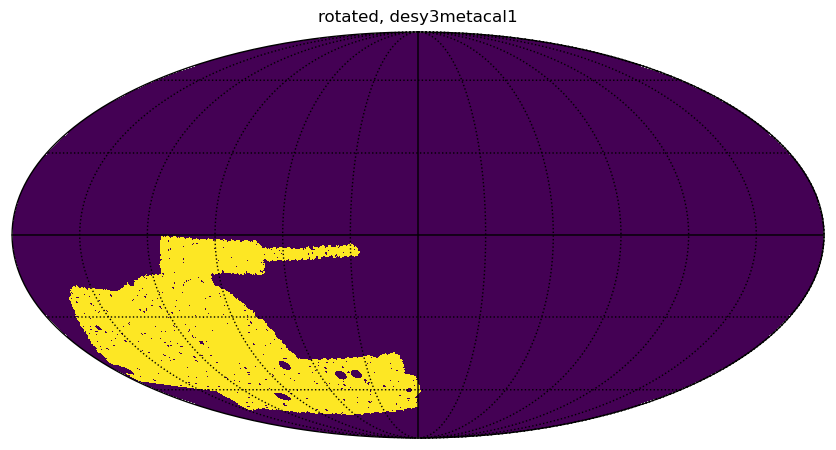

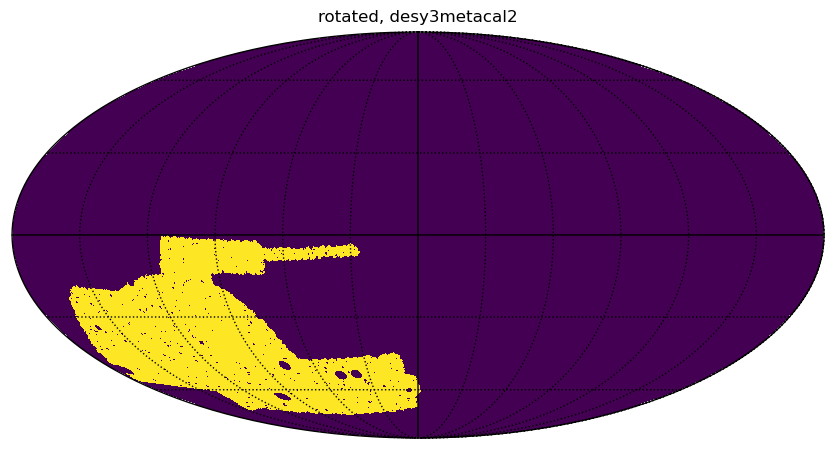

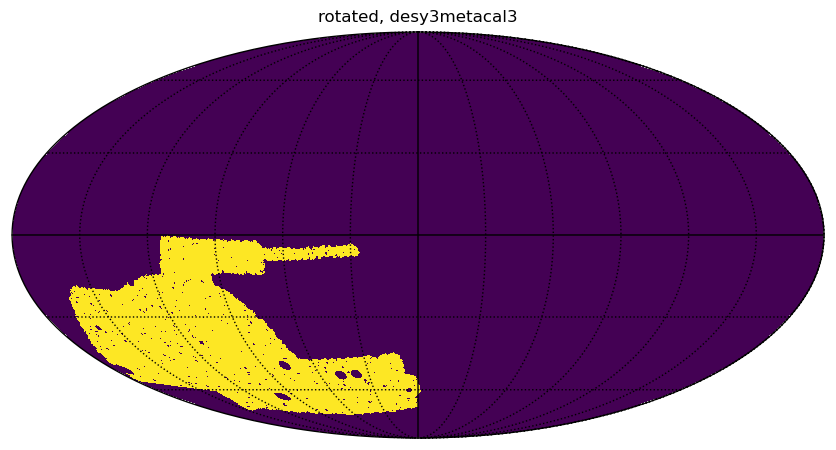

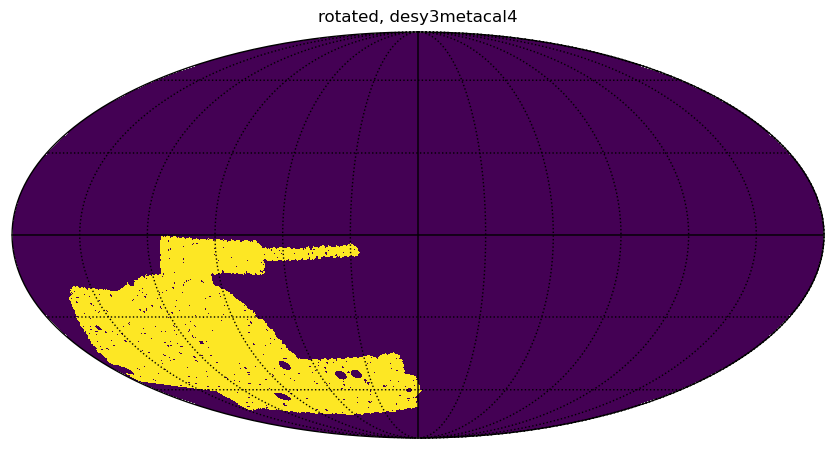

In [155]:
rot_pix_ring_list = []
rot_pix_nest_list = []

# loop over tomographic bins
for vec, z_bin in zip(vec_list, z_bins):
    # vec.shape = (n_galaxies, 3)
    rotated_vec = np.dot(y_rot, vec.T)

    # rotated_vec.shape = (3, n_galaxies)
    rotated_vec = np.dot(z_rot, rotated_vec)

    # convert the vectors to pixels
    rot_pix_ring = hp.vec2pix(n_side, rotated_vec[0], rotated_vec[1], rotated_vec[2])
    rot_pix_nest = hp.vec2pix(n_side, rotated_vec[0], rotated_vec[1], rotated_vec[2], nest=True)

    rot_pix_ring_list.append(rot_pix_ring)
    rot_pix_nest_list.append(rot_pix_nest) 

    # plot the rotated mask
    rot_mask = np.zeros(n_pix)
    rot_mask[rot_pix_ring] = 1
    hp.mollview(rot_mask, title=f"rotated, {z_bin}", cbar=False)
    hp.graticule()

In [156]:
# loop over tomographic bins and remove double counting
footprint_ring_list = []
footprint_nest_list = []
for rot_pix_ring, rot_pix_nest in zip(rot_pix_ring_list, rot_pix_nest_list):
    footprint_ring_list.append(np.unique(rot_pix_ring))
    footprint_nest_list.append(np.unique(rot_pix_nest))

### symmetry transforms (all patches for all bins)

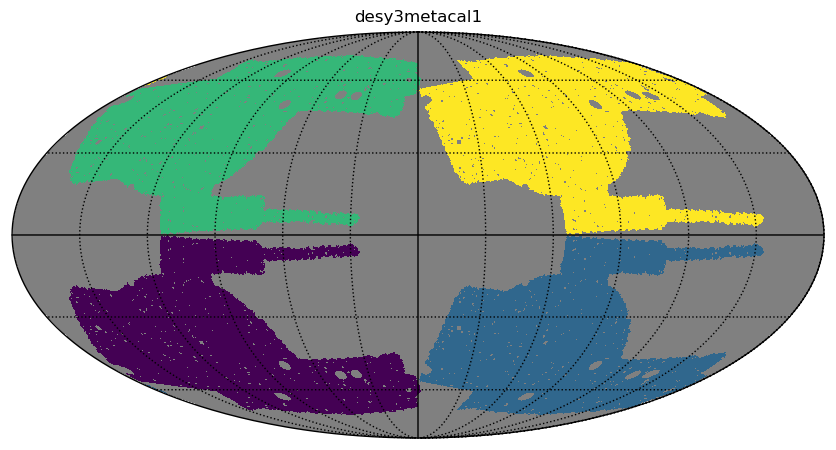

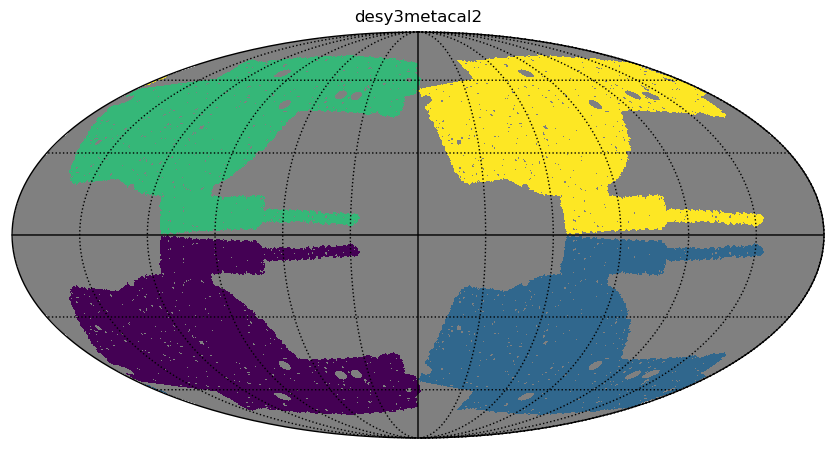

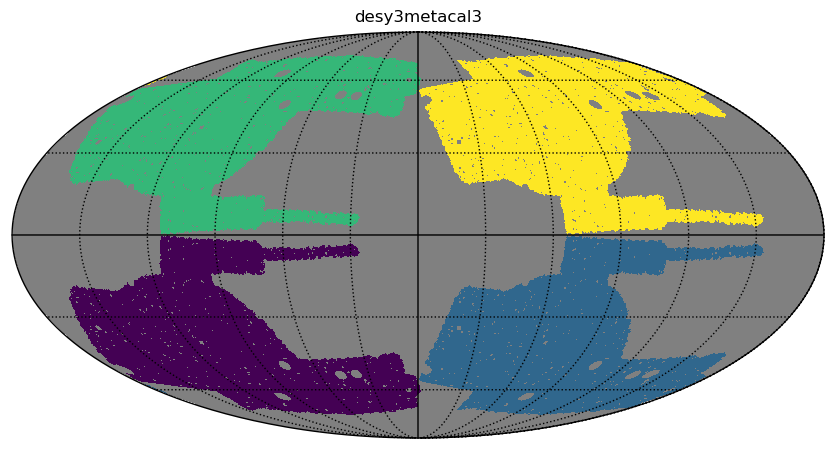

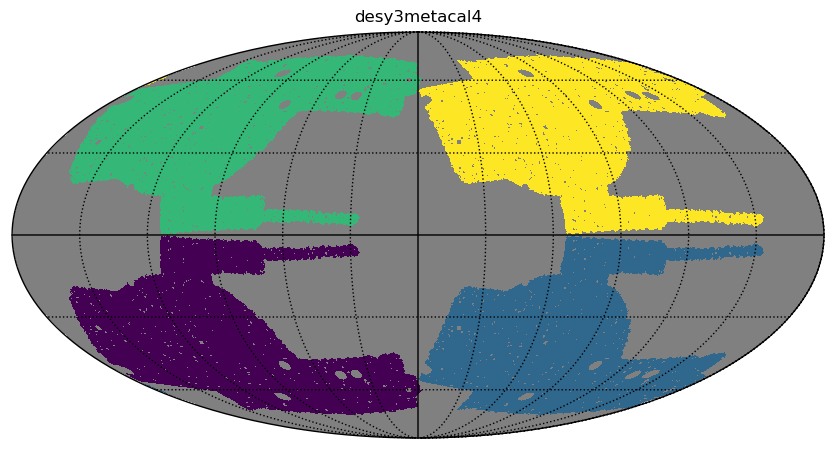

In [157]:
# loop over the the tomographic bins
patches = []
for patch_0, z_bin in zip(footprint_ring_list, z_bins):
    # perform symmetry transformations
    patch_1 = rotate_pix(patch_0, n_rot=2)
    patch_2 = mirror_pix(patch_0, lr=False)
    patch_3 = mirror_pix(patch_0, lr=False)
    patch_3 = rotate_pix(patch_3, n_rot=2)

    # all patches have the same size
    assert len(patch_0) == len(patch_1) == len(patch_2) == len(patch_3)
    # no index occurs more than once
    assert reduce(np.intersect1d, ([patch_0, patch_1, patch_2, patch_3])).size == 0

    patches.append(np.stack([patch_0, patch_1, patch_2, patch_3]))

    # plot the total mask
    full_mask = np.full(n_pix, hp.UNSEEN)
    full_mask[patch_0] = 0
    full_mask[patch_1] = 1
    full_mask[patch_2] = 2
    full_mask[patch_3] = 3

    hp.mollview(full_mask, title=z_bin, cbar=False)
    hp.graticule()

In [158]:
# check the shapes, i.e. number of pixels for each patch
print([p.shape for p in patches])

[(4, 371012), (4, 370979), (4, 370982), (4, 370671)]


In [159]:
# save the patches
with h5py.File(pixels_dir, "a") as f:
    base_grp = f.create_group("metacal/")

    base_grp.attrs["info"] = "This group contains the datasets related to the Metacalibration galaxy sample. "    
                            # "necessary to efficently cut " \
                            #  "out 4 patches of the DES Y3 data for all four tomographic bins " \
                            #  "and package it for a TFR file. " \
                            #  "The idea is the following: " \
                            #  "One can create a data vector out of zeros (for the padding) and then " \
                            #  "add the data by doing data_vec[RING_patches_to_data_vec_bin_{i_bin}] " \
                            #  "m[patch_ids_RING_tomo_{i_bin}[j]] where j runs over all 4 patches and " \
                            #  "m is the map to extract data from, the other vectors indicate datasets."


    dset = f.create_dataset("metacal/gamma_2_sign", data=[1, 1, -1, -1], dtype="i")
    dset.attrs["info"] = "This dataset contains the factor by which the gamma_2 component of the shear maps has to " \
                         "be multiplied. For patches that contain mirroring, gamma_2 needs to be multiplied by " \
                         "minus one. The rotations by 90 degrees are fine."

    for patch, z_bin in zip(patches, z_bins):
        dset = f.create_dataset(f"metacal/patches/{z_bin}", data=patch, dtype="i")
        dset.attrs["info"] = f"This dataset contains all pixel ids for a map with nside {n_side} in RING ordering, " \
                             "to cut out 4 DES Y3 data patches simulataneously. " \
                             "The shape is (N_patches, N_pix), the first patch is the original (but rotated) one. " \
                             f"Data is for tomo bin: {z_bin}"

# Maglim

### Martin's Mask

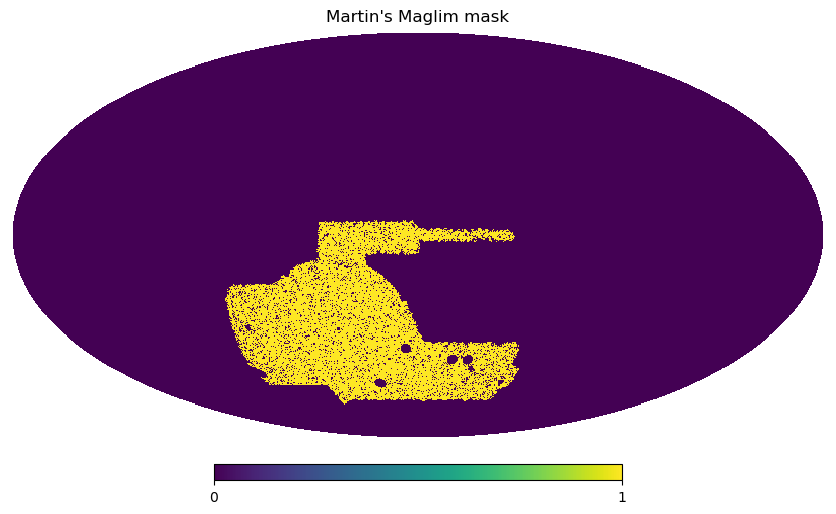

In [178]:
martin_dir = f"/Users/arne/data/DESY3/masks/y3_gold_2.2.1_RING_joint_redmagic_v0.5.1_wide_maglim_v2.2_mask.fits.gz"

data, header = fits.getdata(martin_dir, header = True)
martin_inds = data["HPIX"]

maglim_mask = np.zeros(hp.nside2npix(4096))
maglim_mask[martin_inds] = 1
hp.mollview(maglim_mask, title="Martin's Maglim mask")

# rotate the mask
rotator = hp.Rotator(rot=(0, 0.125, -1.22), eulertype="Y", deg=False)

rot_maglim_mask = rotator.rotate_map_pixel(maglim_mask)
rot_maglim_mask = hp.ud_grade(rot_maglim_mask, nside_out=n_side)

threshold = 0.5
rot_maglim_mask[rot_maglim_mask >= threshold] = 1
rot_maglim_mask[rot_maglim_mask < threshold] = 0

hp.mollview(rot_maglim_mask, title="Martin's Maglim mask rotated")

### original mask

In [179]:
# # provided by Martin Rodriguez Monroy
# martin_dir = f"/Users/arne/data/DESY3/masks/maglim_mask_nside_{n_side}.fits.gz"

# data, header = fits.getdata(martin_dir, header = True)
# martin_inds = data["HPIX"]

# maglim_mask = np.zeros(n_pix)
# maglim_mask[martin_inds] = 1
# hp.mollview(maglim_mask, title="Martin's Maglim mask")

# # upsample
# n_side_up = 4096
# n_pix_up = hp.nside2npix(n_side_up)

# up_maglim_mask = hp.ud_grade(maglim_mask, nside_out=n_side_up)
# up_maglim_mask[up_maglim_mask > 0] = 1
# hp.mollview(up_maglim_mask, title=f"upsampled to {n_side_up} Martin's Maglim mask")

# upsampled_martin_inds = np.arange(n_pix_up)[up_maglim_mask.astype(bool)]

### rotated mask

In [161]:
# vecs = np.stack(hp.pix2vec(nside=n_side, ipix=martin_inds, nest=False))

# # print(vecs)

# # apply rotations
# rotated_vec = np.dot(y_rot, vecs)
# rotated_vec = np.dot(z_rot, rotated_vec)

# # convert the vectors to pixels
# rot_pix_ring = hp.vec2pix(n_side, rotated_vec[0], rotated_vec[1], rotated_vec[2])
# rot_pix_nest = hp.vec2pix(n_side, rotated_vec[0], rotated_vec[1], rotated_vec[2], nest=True)

# # plot the rotated mask
# rot_mask = np.zeros(n_pix)
# rot_mask[rot_pix_ring] = 1
# hp.mollview(rot_mask, title=f"rotated maglim mask", cbar=False)#, rot=(40, 0, 0))
# hp.graticule()

In [162]:
# vecs = np.stack(hp.pix2vec(nside=n_side_up, ipix=upsampled_martin_inds, nest=False))

# # print("vecs")
# # print(vecs.shape)
# # print(vecs[:,[0, 100, 1000, 10000, 100000, 1000000]])

# # apply rotations
# rotated_vec = np.dot(y_rot, vecs)
# rotated_vec = np.dot(z_rot, rotated_vec)

# # print("rotated vecs")
# # print(rotated_vec.shape)
# # print(rotated_vec[:,[0, 100, 1000, 10000, 100000, 1000000]])

# # convert the vectors to pixels
# rot_pix_ring = hp.vec2pix(n_side_up, rotated_vec[0], rotated_vec[1], rotated_vec[2])
# # rot_pix_nest = hp.vec2pix(2048, rotated_vec[0], rotated_vec[1], rotated_vec[2], nest=True)

# # print(np.sum(rot_pix_ring))
# # print(rot_pix_ring.shape)

# # make a rotated mask
# rot_mask = np.zeros(hp.nside2npix(n_side_up))
# rot_mask[rot_pix_ring] = 1

# rot_mask = hp.ud_grade(rot_mask, nside_out=n_side)

# threshold = 0.5
# rot_mask[rot_mask >= threshold] = 1
# rot_mask[rot_mask < threshold] = 0
# rot_mask = rot_mask.astype(int)

# # plot the rotated mask
# hp.mollview(rot_mask, title=f"rotated maglim mask", cbar=False)#, rot=(40, 0, 0))
# hp.graticule()

# print(np.sum(rot_mask))
# print(np.sum(rot_mask) - 384485.0)
# print(np.sum(rot_mask) / 384485.0)

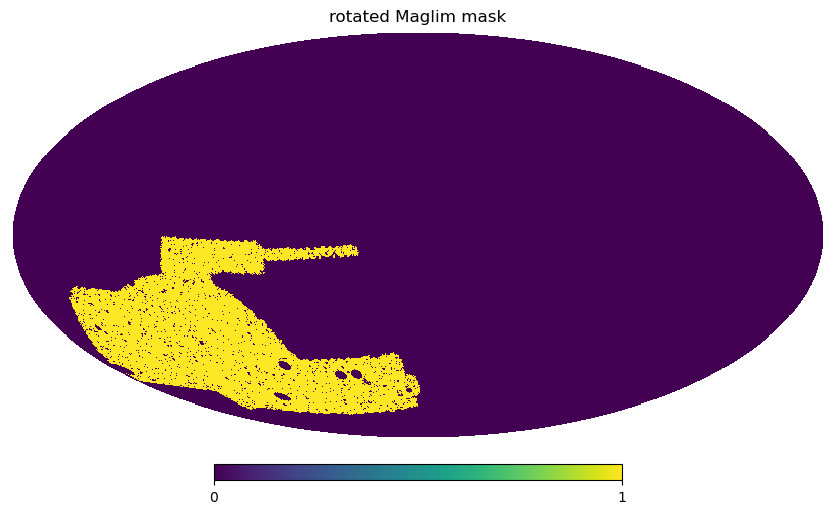

In [184]:
rotator = hp.Rotator(rot=(0, 0.125, -1.22), eulertype="Y", deg=False)

# rot_maglim_mask = rotator.rotate_map_pixel(hp.ud_grade(maglim_mask, nside_out=4096))
rot_maglim_mask = rotator.rotate_map_pixel(maglim_mask)
rot_maglim_mask = hp.ud_grade(rot_maglim_mask, nside_out=n_side)

threshold = 0.5
rot_maglim_mask[rot_maglim_mask >= threshold] = 1
rot_maglim_mask[rot_maglim_mask < threshold] = 0

hp.mollview(rot_maglim_mask, title="rotated Maglim mask")

### symmetry transforms

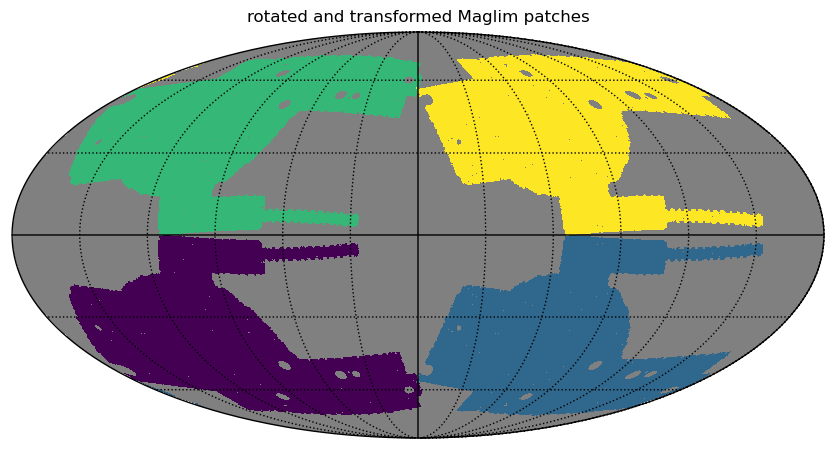

In [164]:
patch_0 = np.arange(n_pix)[rot_maglim_mask.astype(bool)]

patch_1 = rotate_pix(patch_0, n_rot=2)

patch_2 = mirror_pix(patch_0, lr=False)

patch_3 = mirror_pix(patch_0, lr=False)
patch_3 = rotate_pix(patch_3, n_rot=2)

# all patches have the same size
assert len(patch_0) == len(patch_1) == len(patch_2) == len(patch_3)
# no index occurs more than once
assert reduce(np.intersect1d, ([patch_0, patch_1, patch_2, patch_3])).size == 0

maglim_patches = np.stack([patch_0, patch_1, patch_2, patch_3])

# plot the total mask
full_mask = np.full(n_pix, hp.UNSEEN)
full_mask[patch_0] = 0
full_mask[patch_1] = 1
full_mask[patch_2] = 2
full_mask[patch_3] = 3

hp.mollview(full_mask, title="rotated and transformed Maglim patches", cbar=False)
hp.graticule()

In [165]:
# save the patches
with h5py.File(pixels_dir, "a") as f:
    dset = f.create_dataset(f"maglim/patches", data=maglim_patches, dtype="i")
    dset.attrs["info"] = f"This dataset contains all pixel ids for a map with nside {n_side} in RING ordering, " \
                        "to cut out 4 DES Y3 data patches simulataneously. " \
                        "The shape is (N_patches, N_pix), the first patch is the original (but rotated) one. " \
                        f"Data is for all tomo bins"

    # dset = f.create_dataset(f"maglim/patches/NEST", data=maglim_patches_nest, dtype="i")
    # dset.attrs["info"] = "This dataset contains all pixel ids for a map with nside " \
    #                         f"{n_side} in RING ordering, to cut out 4 DES Y3 data patches simulataneously. " \
    #                         "The shape is (N_patches, N_pix), first patch is the original one. " \
    #                         f"Data is for tomo bin: {z_bin}"

### Extend the indices, i.e. padding for network

Metacal only union has       371871 pixels
Metacal and Maglim union has 387236 pixels
desy3metacal1 has length 371012
desy3metacal2 has length 370979
desy3metacal3 has length 370982
desy3metacal4 has length 370671


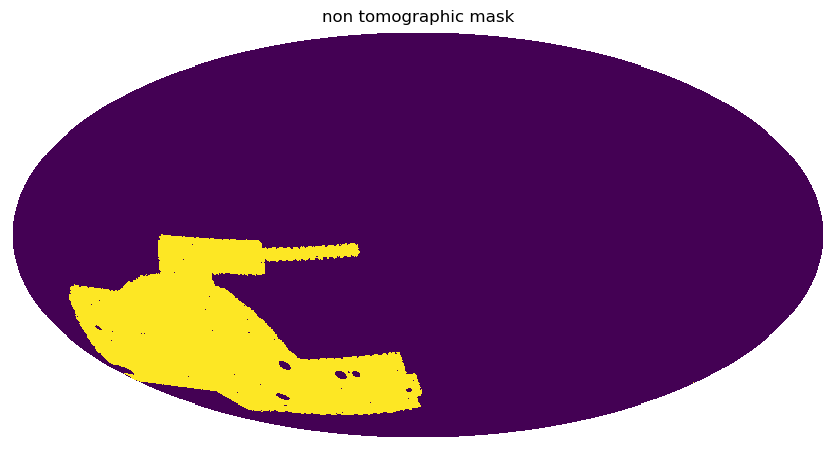

In [166]:
# get the non-tomo mask in NEST, Metacal
non_tomo_pixels_nest = reduce(np.union1d, footprint_nest_list)
print(f"Metacal only union has       {len(non_tomo_pixels_nest)} pixels")

# add Maglim indices
maglim_patch_nest = hp.ring2nest(n_side, maglim_patches[0,:])
non_tomo_pixels_nest = reduce(np.union1d, [non_tomo_pixels_nest, maglim_patch_nest])
print(f"Metacal and Maglim union has {len(non_tomo_pixels_nest)} pixels")

# check
for footprint, name in zip(footprint_nest_list, z_bins):
    print(f"{name} has length {len(footprint)}")
    assert len(non_tomo_pixels_nest) > len(footprint)

# plot the corresponding mask, which is the union of all Metacal and Maglim masks
non_tomo_mask_nest = np.zeros(n_pix)
non_tomo_mask_nest[non_tomo_pixels_nest] = 1
hp.mollview(non_tomo_mask_nest, nest=True, cbar=False, title="non tomographic mask")

nside=16, npix=465.0
nside=512, npix=476160.0


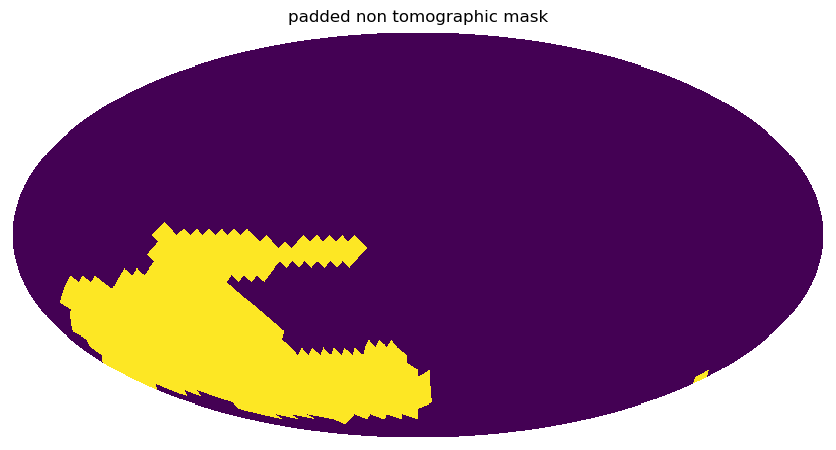

In [167]:
# minimal possible nside for the network to downsample
padded_mask_nest = hp.ud_grade(non_tomo_mask_nest, nside_out=n_side_down, order_in='NEST', order_out='NEST')
padded_mask_nest[padded_mask_nest > 0] = 1
print(f"nside={n_side_down}, npix={np.sum(padded_mask_nest)}")

padded_mask_nest = hp.ud_grade(padded_mask_nest, nside_out=n_side, order_in='NEST', order_out='NEST')
padded_mask_nest[padded_mask_nest > 0] = 1
print(f"nside={n_side}, npix={np.sum(padded_mask_nest)}")

# check the padded patch
hp.mollview(padded_mask_nest, nest=True, title="padded non tomographic mask", cbar=False)

In [168]:
# get the pixel in nest ordering (from the mask on map level)
non_tomo_pixels_nest_ext = np.arange(n_pix)[padded_mask_nest > 0.5]
print(f"Non padded: {len(non_tomo_pixels_nest)} pixels")
print(f"Padded:     {len(non_tomo_pixels_nest_ext)} pixels")
assert len(non_tomo_pixels_nest_ext) > len(non_tomo_pixels_nest)

Non padded: 387236 pixels
Padded:     476160 pixels


In [169]:
# save the indices
with h5py.File(pixels_dir, "a") as f:
    dset = f.create_dataset("data_vec", shape=non_tomo_pixels_nest_ext.shape, dtype="i", data=non_tomo_pixels_nest_ext)
    dset.attrs["info"] = "This dataset contains all relevant pixels from the original rotated " \
                         "DES Y3 patch in NEST ordering, such that it can be downsampled to " \
                         f"an nside of {n_side_down} without the need of additional padding."

### Note:

Now comes the tricky part:

The idea for a fast and efficient cut out procedure of the simulated maps is that one can generate data vectors that only consist of zeros (including the padding) and then fill in the necessary pixels. To make this possible, we need to know the correspondence of the pixels inside the data vector (NEST ordering) with pixels in RING ordering of the full sky map.

In [170]:
# dict for fast look up
non_tomo_pixels_nest_ext_look_up = {}
for i, pix_id in enumerate(non_tomo_pixels_nest_ext):
    non_tomo_pixels_nest_ext_look_up.update({pix_id: i})

### Metacal

In [171]:
# list for correspondences
map_to_datavec_pix = []
counter = 0
# loop over tomographic bins, patch_indices are in RING ordering
for patch_index, name in zip(footprint_ring_list, z_bins):
    print("Starting with bin: ", name)
    nest_patch = hp.ring2nest(n_side, patch_index)
    
    # now we need to get the index in non_tomo_pixels_nest_ext that corresponds to the pix id
    corresponding_pix = []
    for pix_id in nest_patch:
        corresponding_pix.append(non_tomo_pixels_nest_ext_look_up[pix_id])
    map_to_datavec_pix.append(np.array(corresponding_pix))
    counter += 1

Starting with bin:  desy3metacal1
Starting with bin:  desy3metacal2
Starting with bin:  desy3metacal3
Starting with bin:  desy3metacal4


In [172]:
# save the patches
with h5py.File(pixels_dir, "a") as f:
    grp = f.create_group("metacal/patch_to_data_vec")
    for i_bin, name in zip(range(len(tomo_inds)), z_bins):
        current_patch = map_to_datavec_pix[i_bin]
        dset = grp.create_dataset(name, shape=current_patch.shape, dtype="i", data=current_patch)
        dset.attrs["info"] = "This dataset contains the pixel ids that map the patches in RING " \
                             "ordering to the data vector in NEST ordering. " \
                             f"Data is for tomo bin: {name}"

### Maglim

In [173]:
maglim_patch_nest = hp.ring2nest(n_side, maglim_patches[0,:])

# now we need to get the index in non_tomo_pixels_nest_ext that corresponds to the pix id
corresponding_pix = []
for pix_id in maglim_patch_nest:
    corresponding_pix.append(non_tomo_pixels_nest_ext_look_up[pix_id])

map_to_datavec_pix = np.array(corresponding_pix)

In [174]:
# save the patches
with h5py.File(pixels_dir, "a") as f:
    dset = f.create_dataset("maglim/patch_to_data_vec", shape=map_to_datavec_pix.shape, dtype="i", data=map_to_datavec_pix)
    dset.attrs["info"] = "This dataset contains the pixel ids that map the patches in RING " \
                            "ordering to the data vector in NEST ordering. " \
                            f"Data is for all tomo bins"

# inspect the file

In [175]:
with h5py.File(pixels_dir, "r") as f:
    print(f.keys())

    print(f["metacal"].keys())
    print(f["maglim"].keys())

    print(f["metacal/patches"].keys())

    print(f["data_vec"][:])

    data_vec_pix = f["data_vec"][:]

<KeysViewHDF5 ['data_vec', 'maglim', 'metacal']>
<KeysViewHDF5 ['gamma_2_sign', 'patch_to_data_vec', 'patches']>
<KeysViewHDF5 ['patch_to_data_vec', 'patches']>
<KeysViewHDF5 ['desy3metacal1', 'desy3metacal2', 'desy3metacal3', 'desy3metacal4']>
[1119232 1119233 1119234 ... 2955261 2955262 2955263]


In [176]:
data_vec_pix, metacal_tomo_patches_pix, metacal_tomo_corresponding_pix, gamma2_signs, maglim_patches_pix, maglim_corresponding_pix = load_pixel_file()

23-04-19 16:13:48  analysis.py INF   Loaded the config 


FileNotFoundError: [Errno 2] Unable to open file (unable to open file: name = '/Users/arne/git/multiprobe-simulation-forward-model/data/DESY3_pixels_512_debug.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [ ]:
metacal_tomo_patches_pix[3].shape

(4, 370671)

In [ ]:
maglim_patches_pix.shape

(4, 384640)

## testing

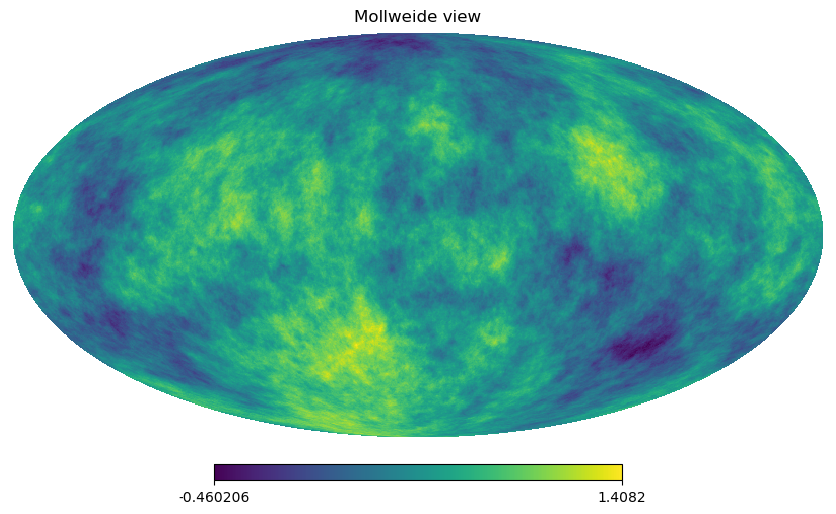

In [ ]:
# we start be generating a random map
np.random.seed(11)
Cl = np.arange(1, 1001)**-3.
example_map = hp.synfast(cls=Cl, nside=n_side)

z_min = np.min(example_map)
z_max = np.max(example_map)

# plot
hp.mollview(example_map, min=z_min, max=z_max)

### cut outs

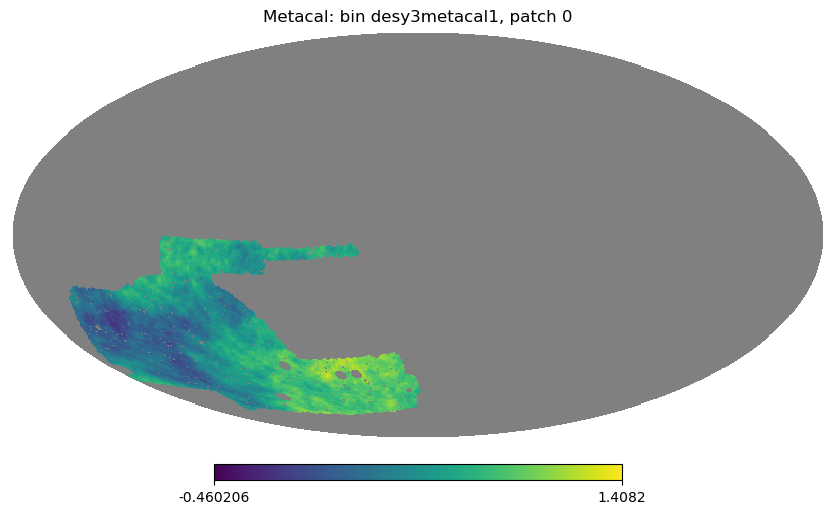

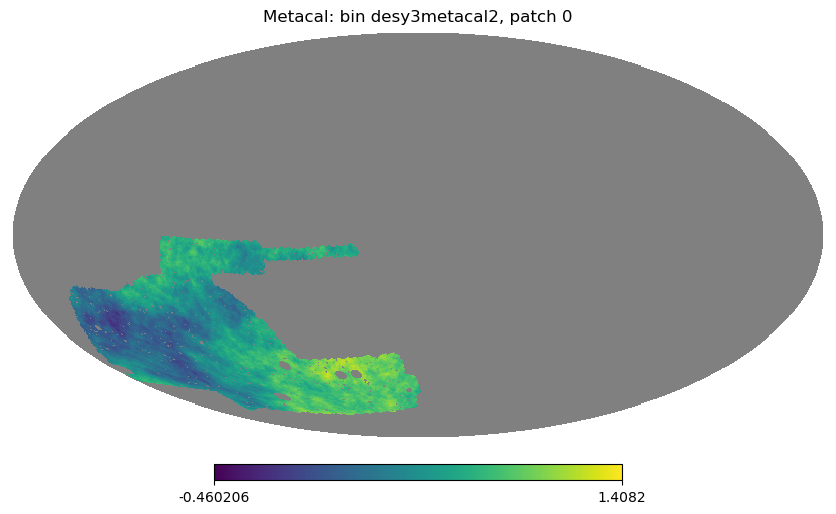

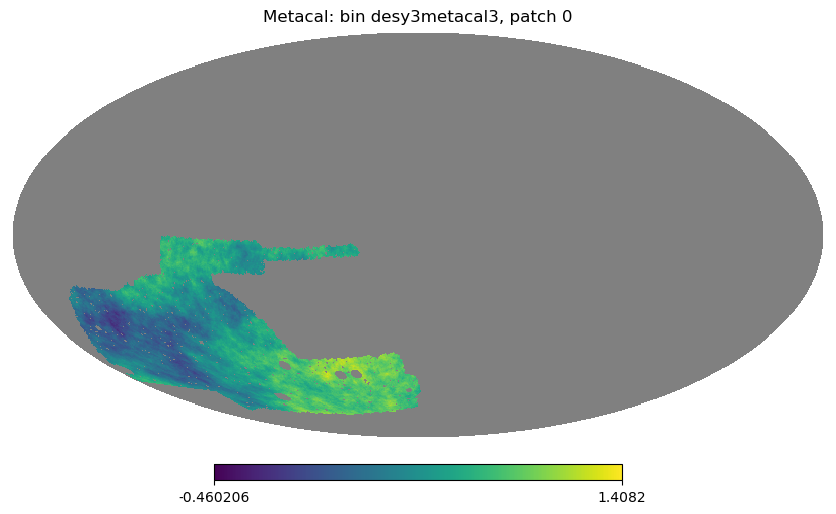

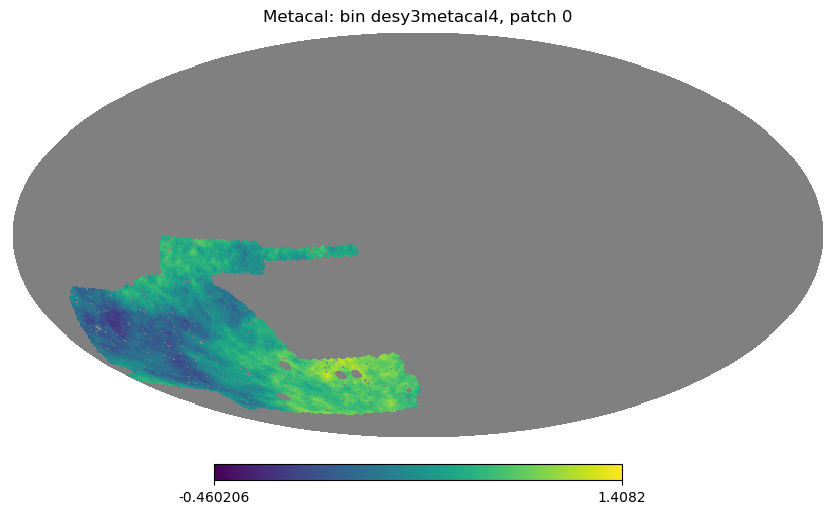

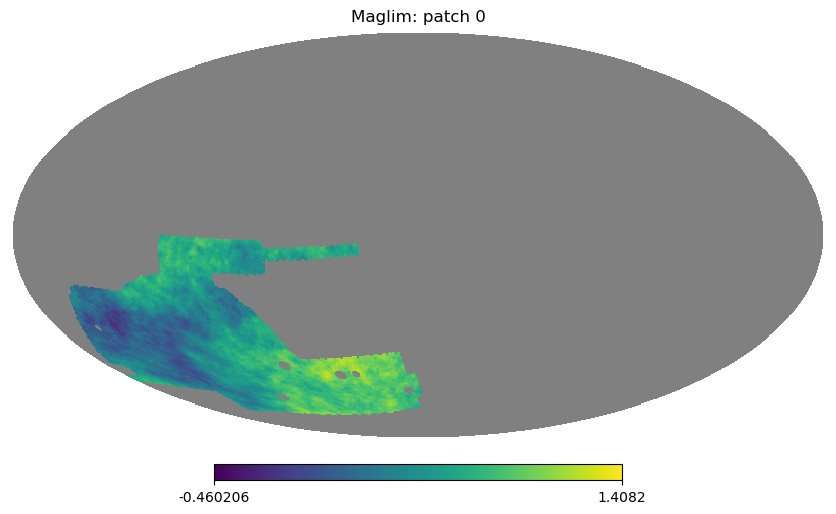

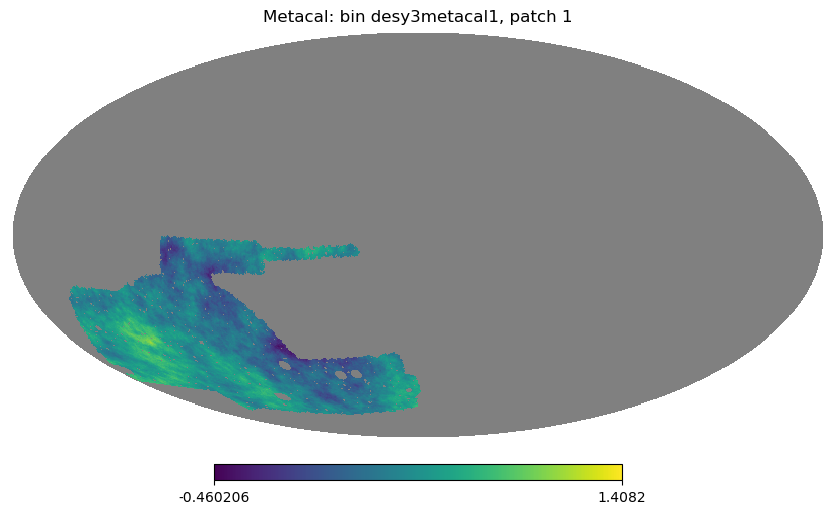

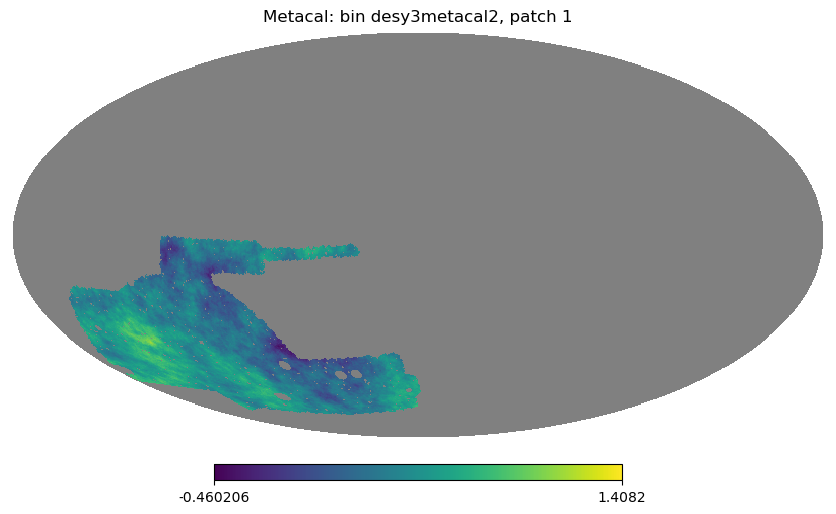

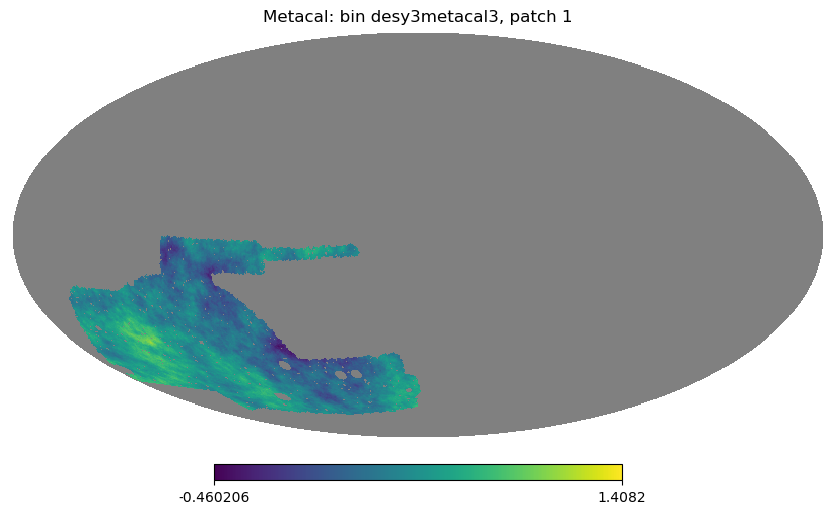

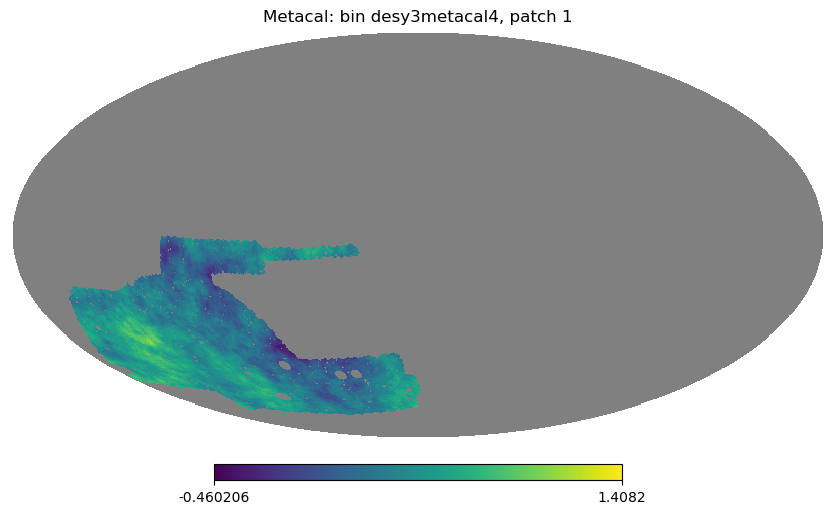

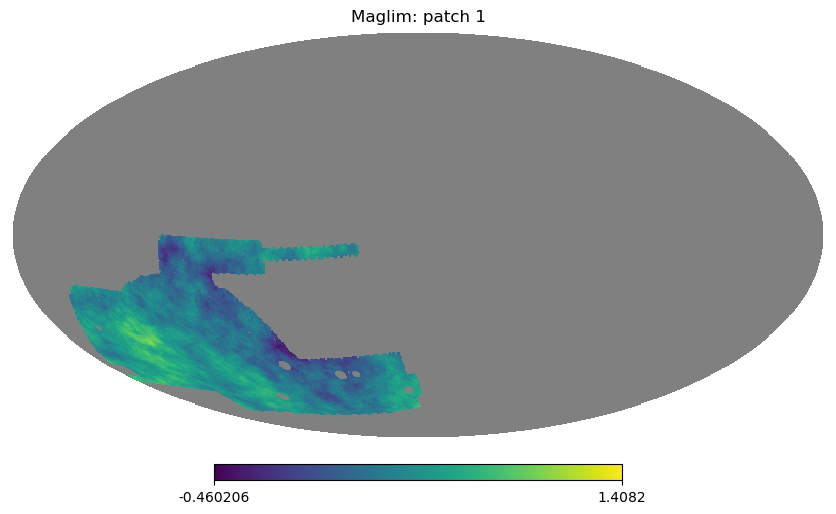

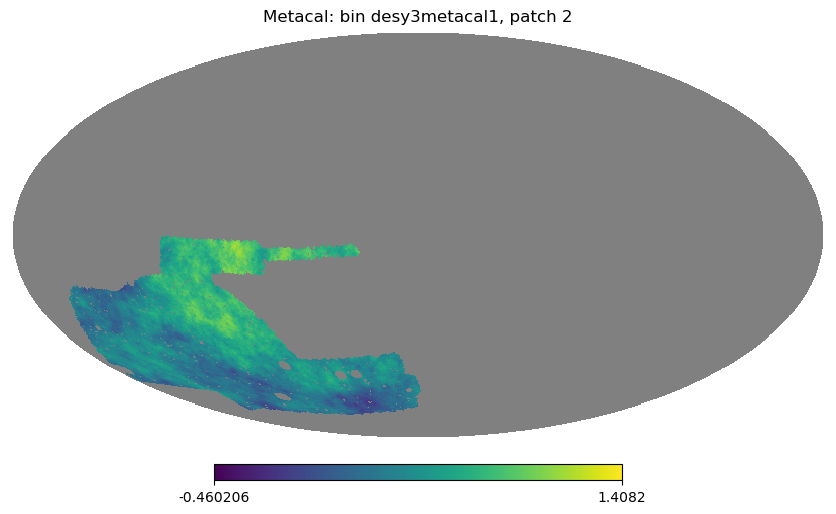

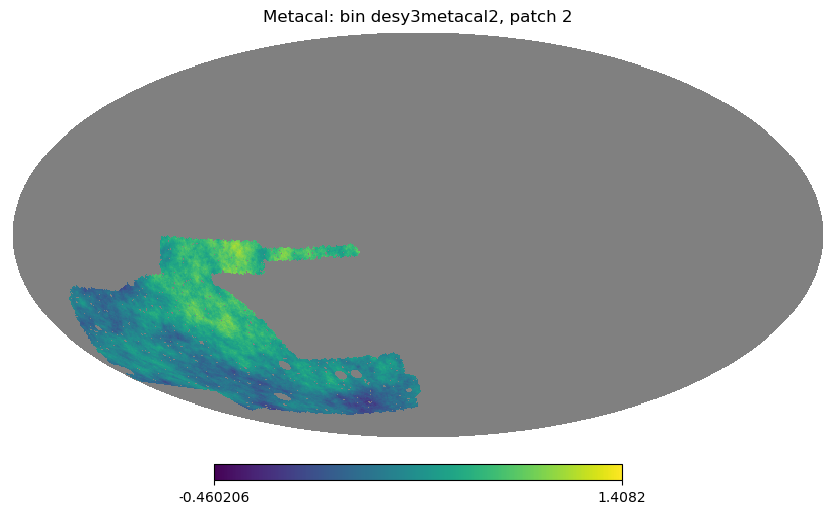

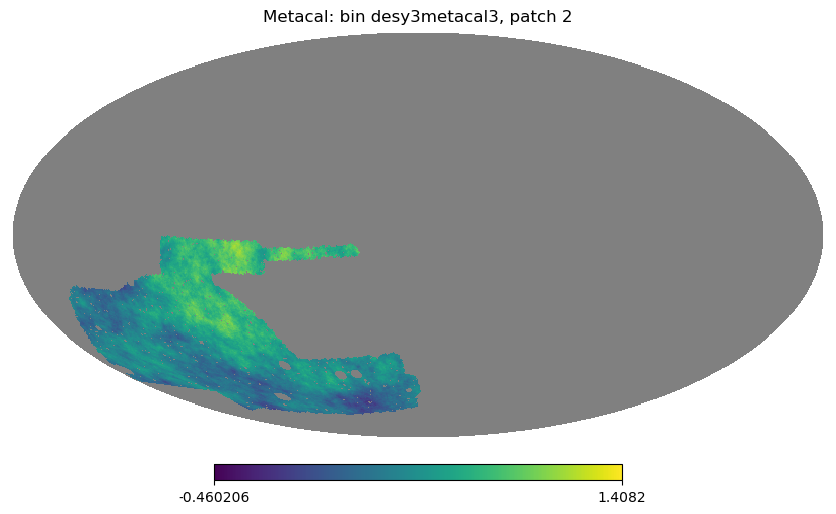

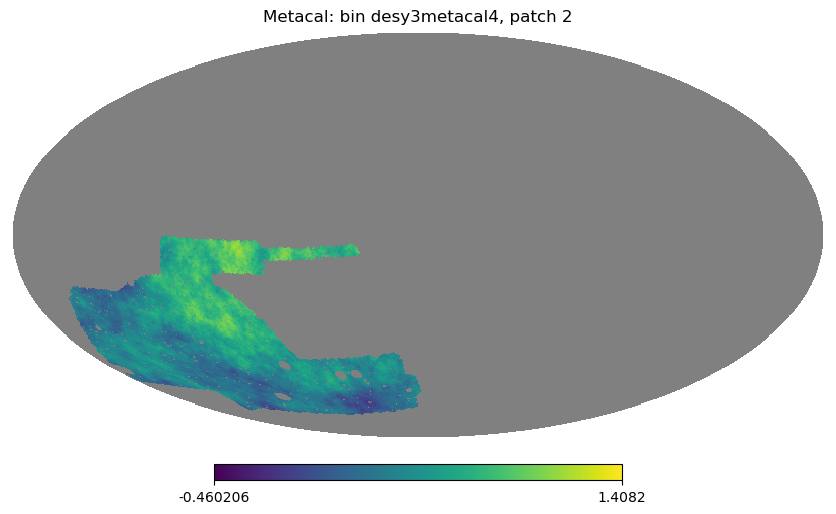

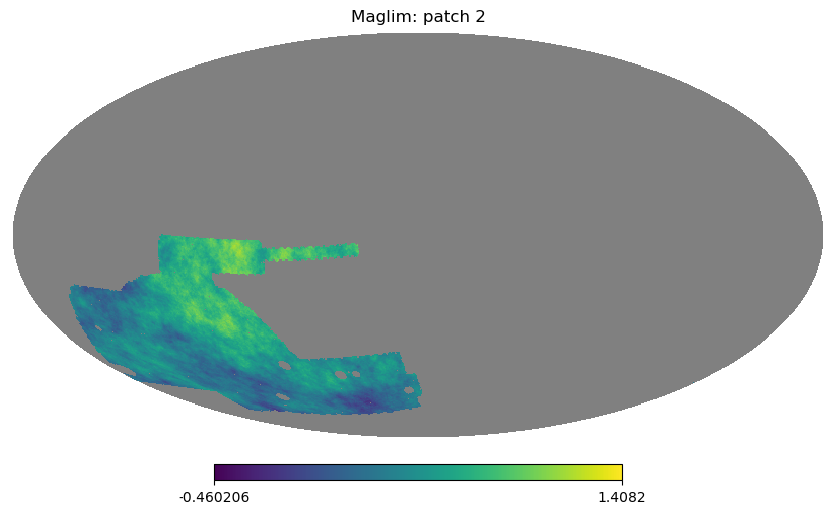

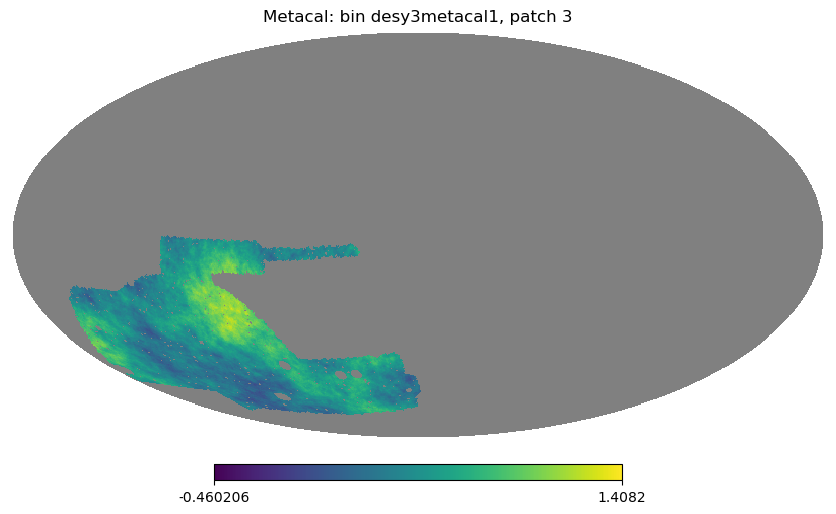

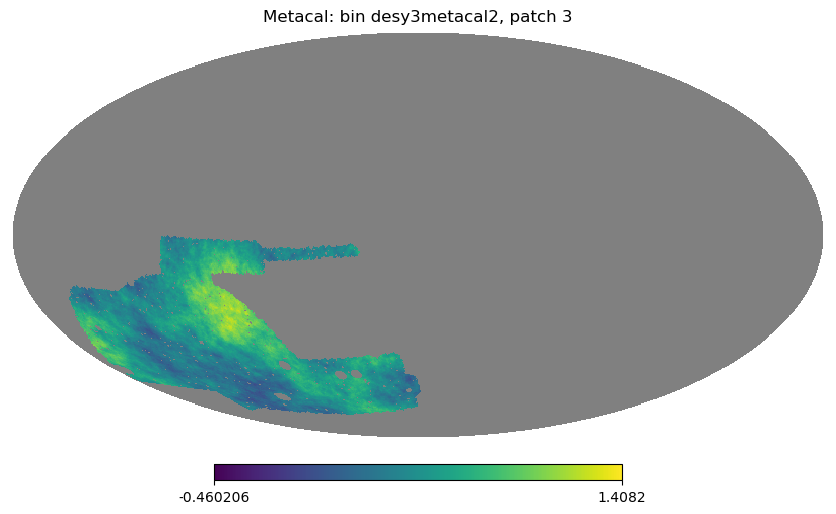

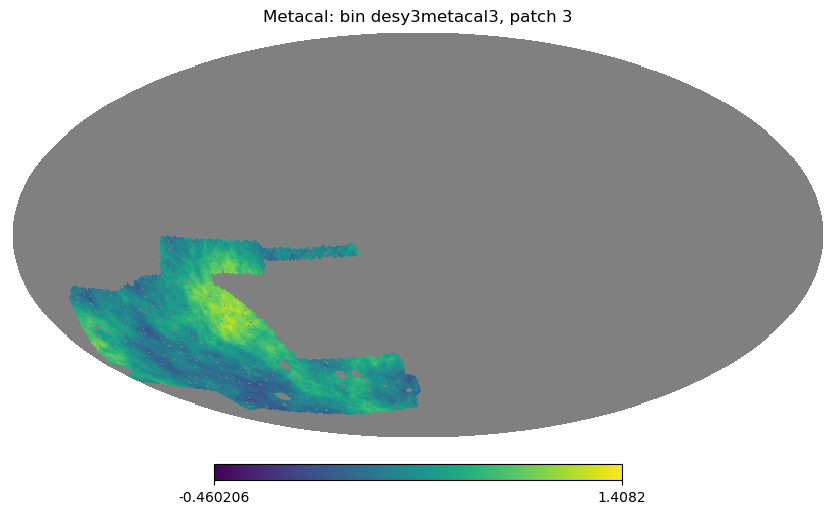

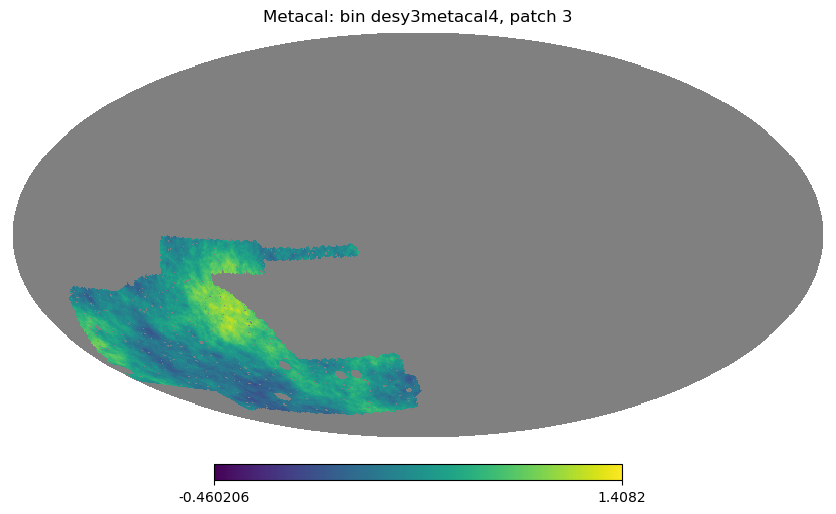

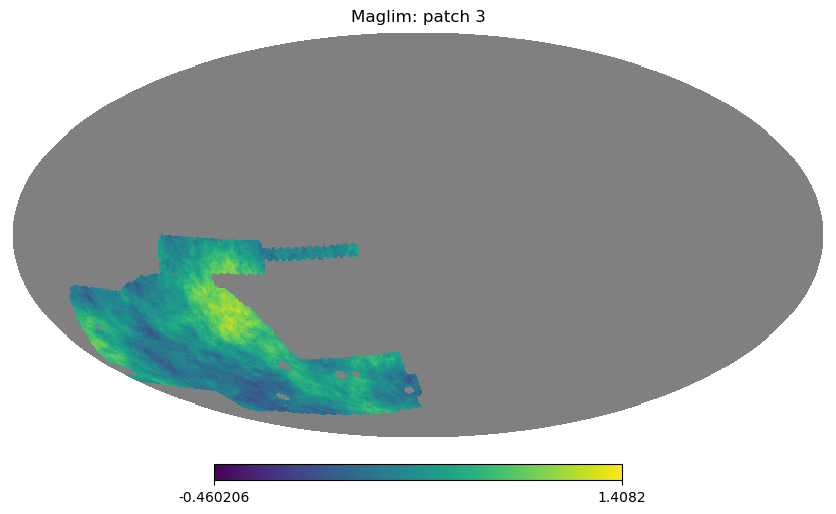

In [ ]:
for patch_id in range(4):
    # Metacal
    for z_id, z_bin in zip(range(4), conf["survey"]["metacal"]["z_bins"]):
        base_patch = metacal_tomo_patches_pix[z_id][0]
        current_patch = metacal_tomo_patches_pix[z_id][patch_id]

        m_plot = np.full(n_pix, hp.UNSEEN)
        m_plot[base_patch] = example_map[current_patch]
        hp.mollview(m_plot, min=z_min, max=z_max, title=f"Metacal: bin {z_bin}, patch {patch_id}")

    # Maglim
    base_patch = maglim_patches_pix[0]
    current_patch = maglim_patches_pix[patch_id]

    m_plot = np.full(n_pix, hp.UNSEEN)
    m_plot[base_patch] = example_map[current_patch]
    hp.mollview(m_plot, min=z_min, max=z_max, title=f"Maglim: patch {patch_id}")

### data vectors

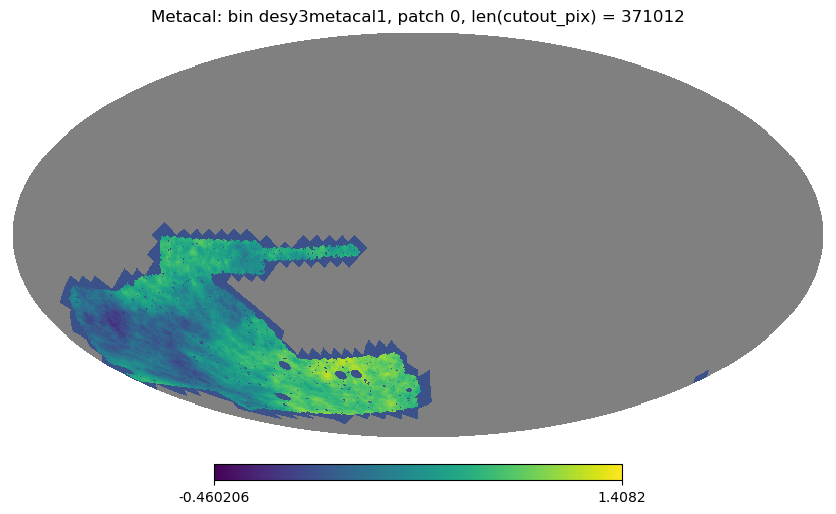

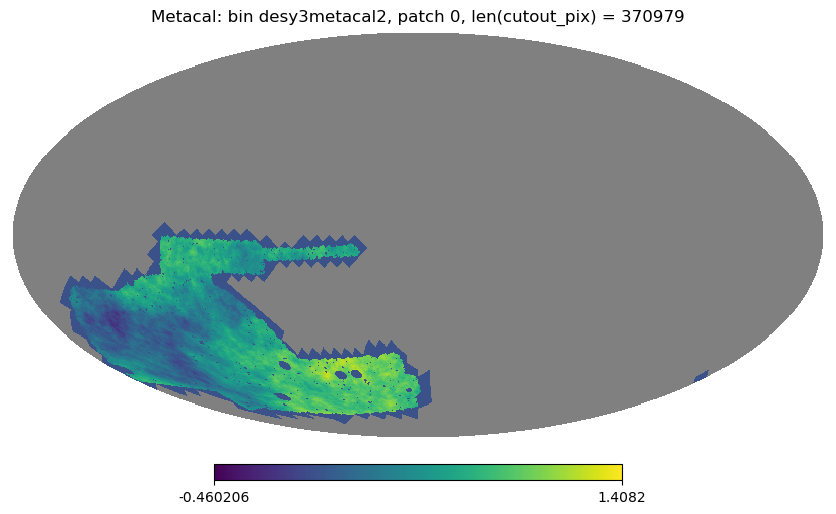

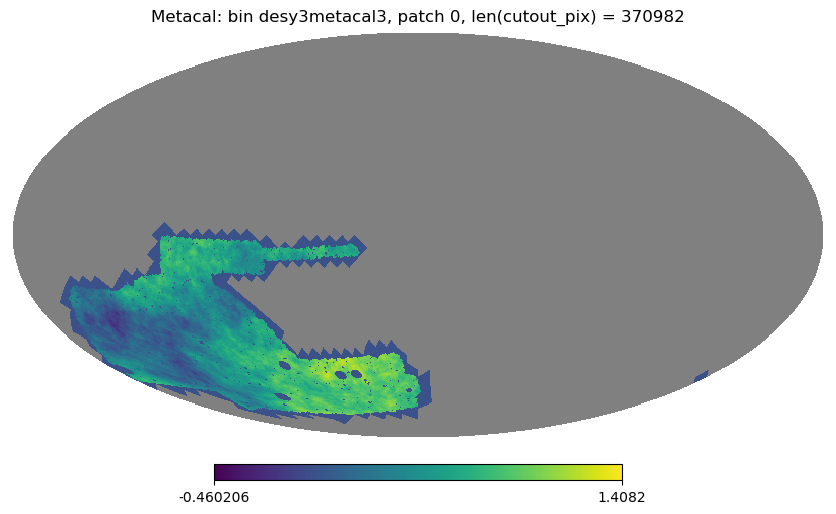

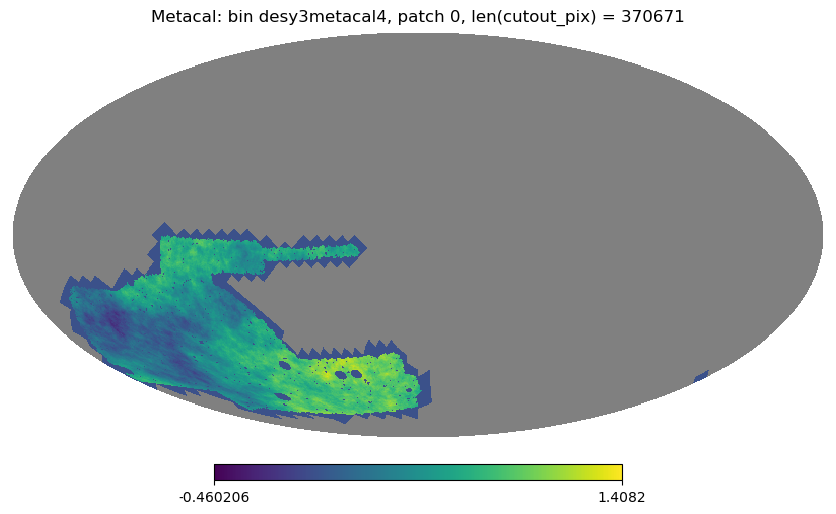

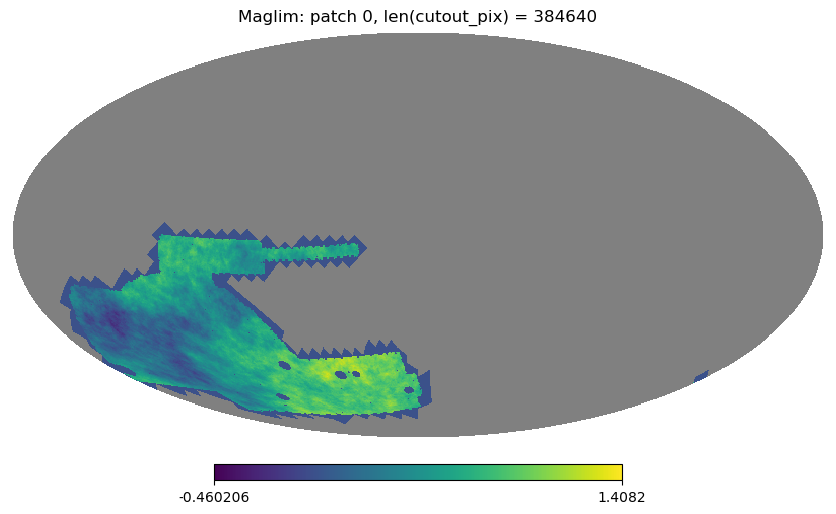

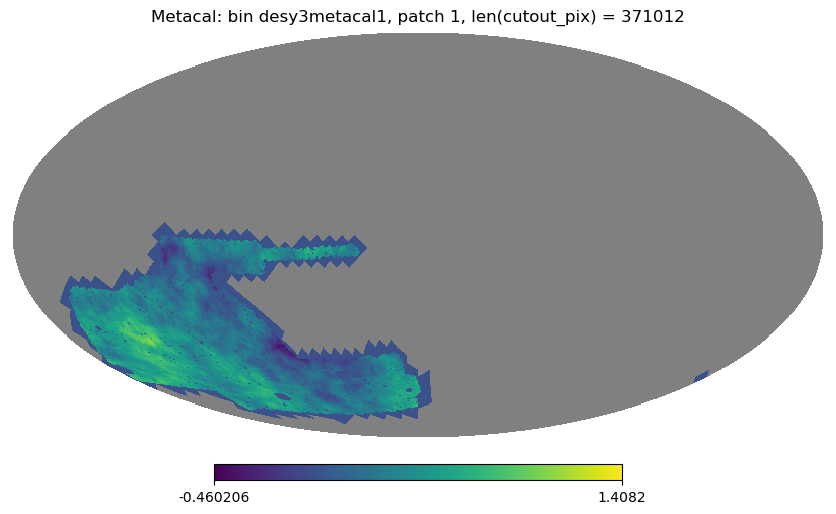

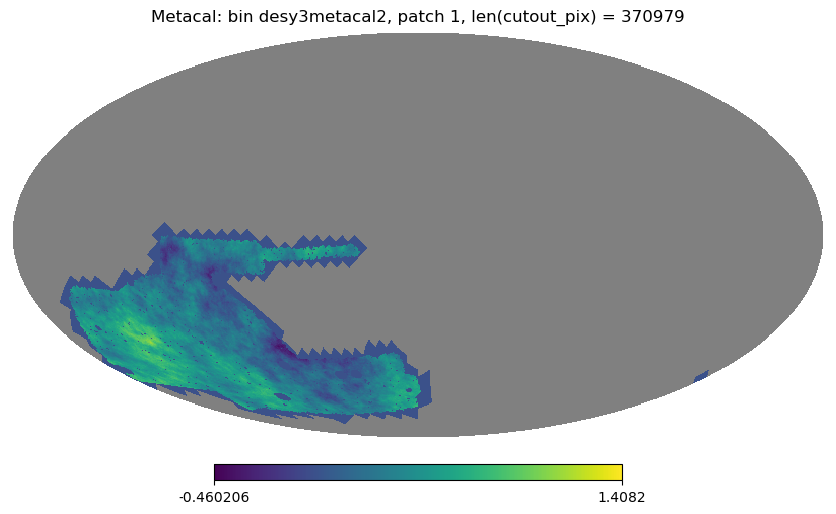

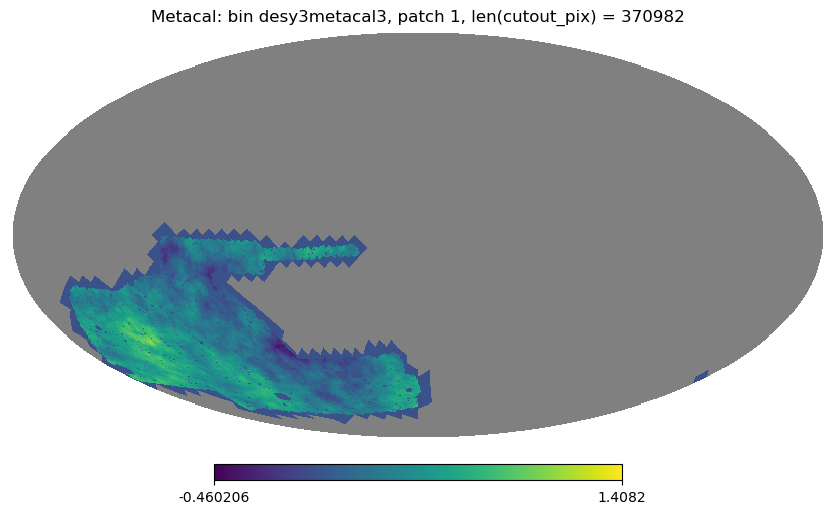

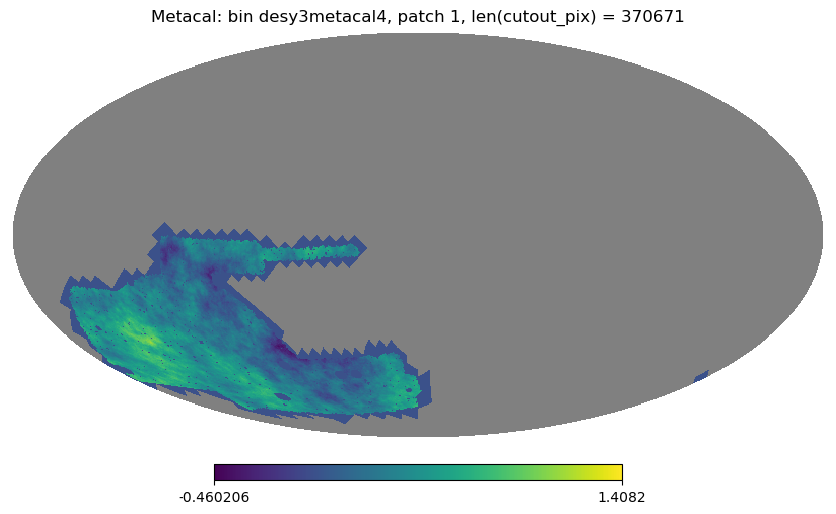

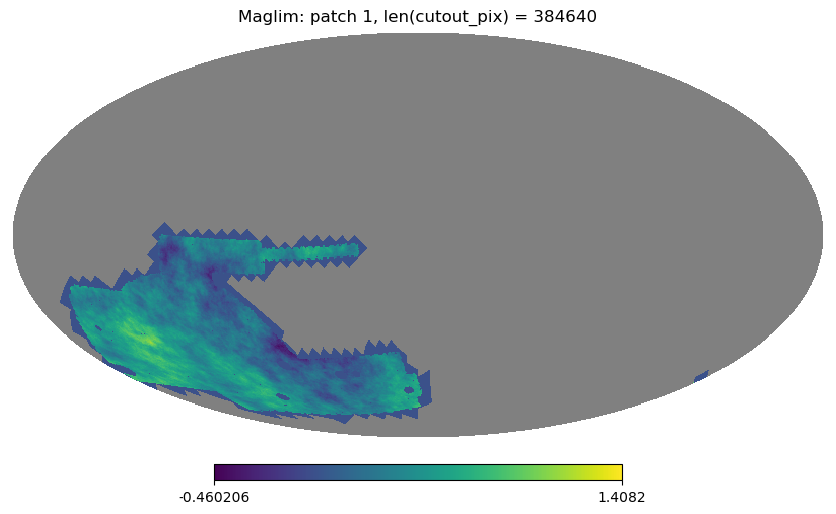

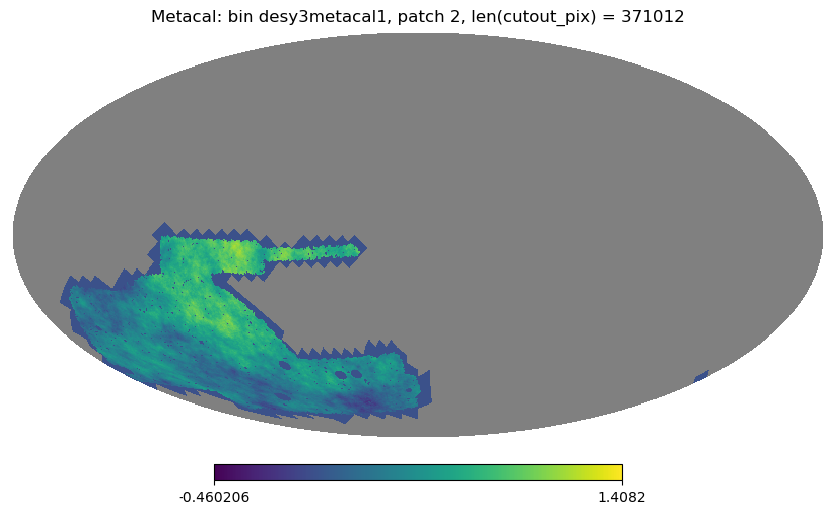

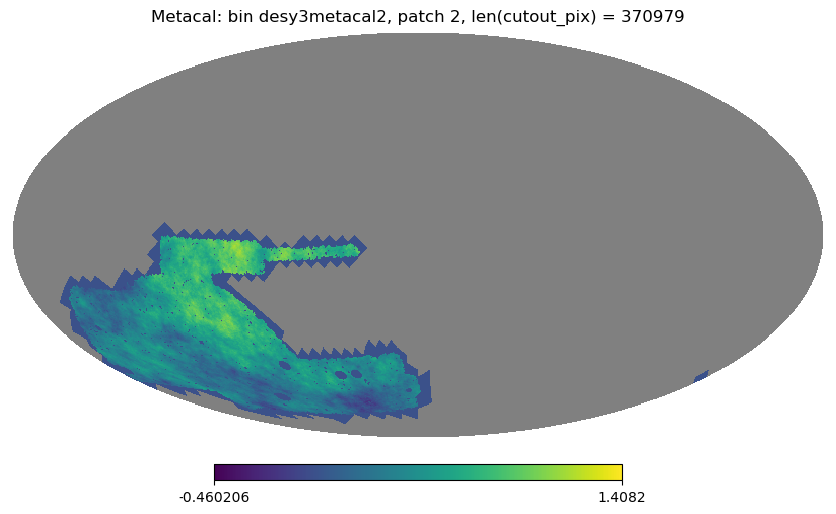

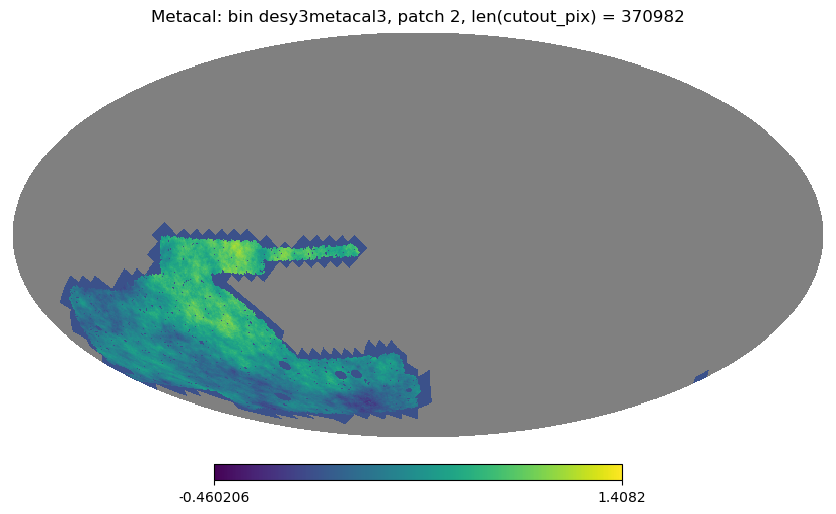

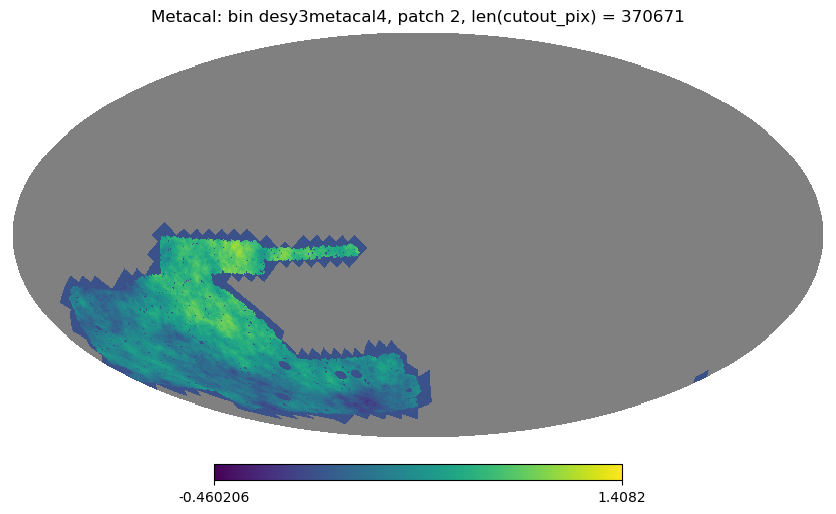

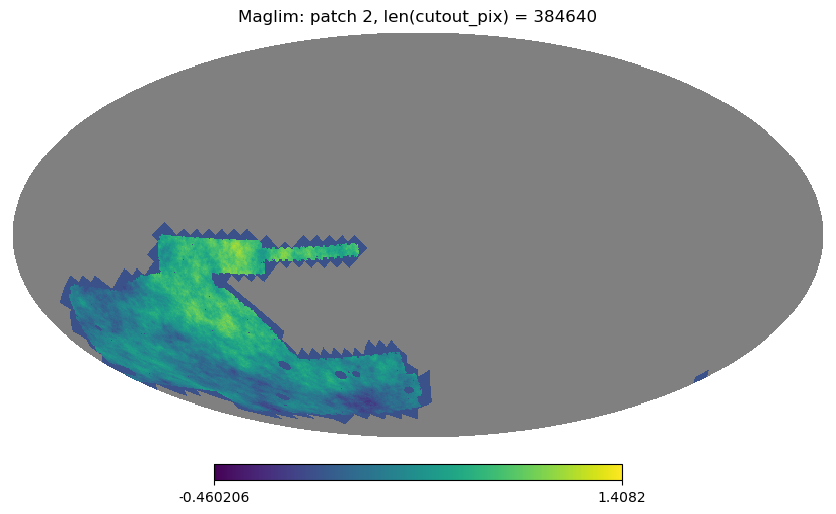

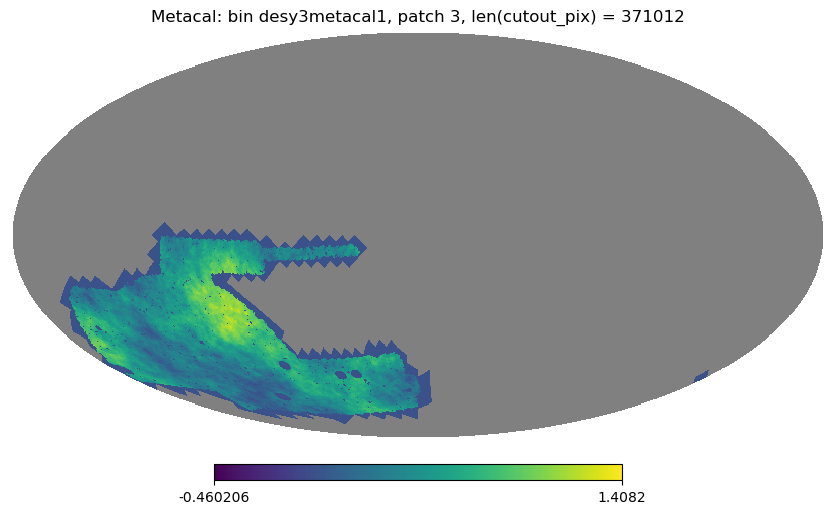

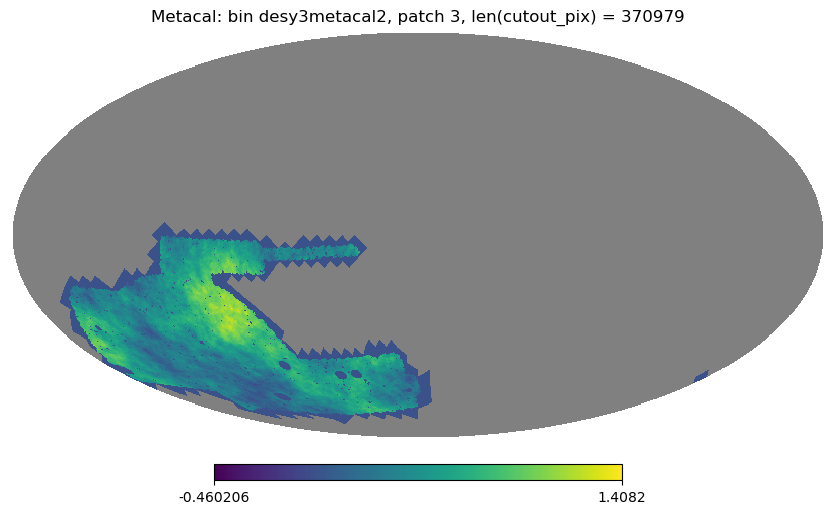

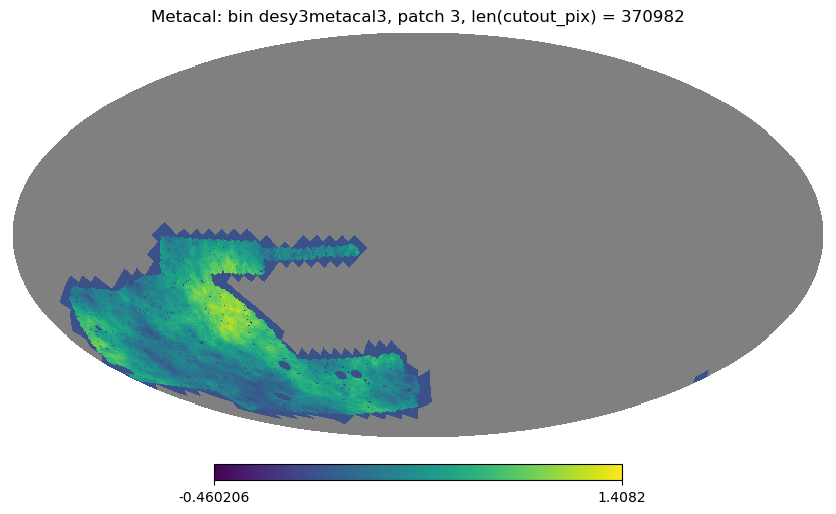

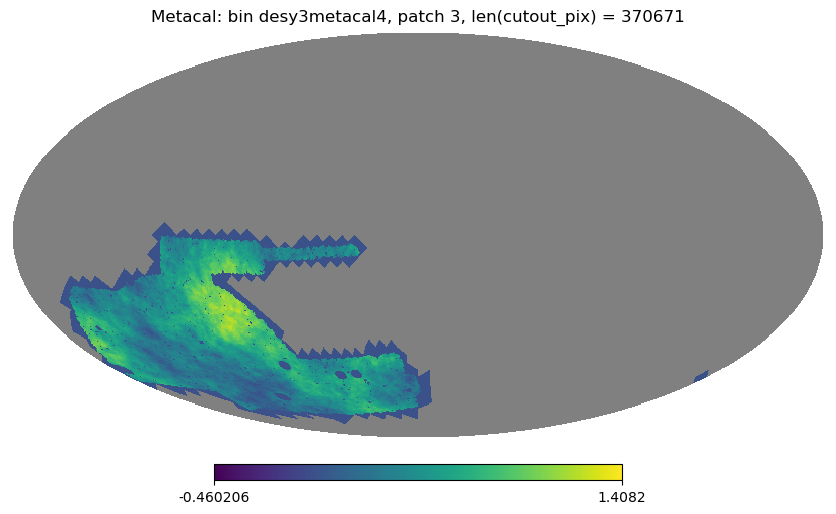

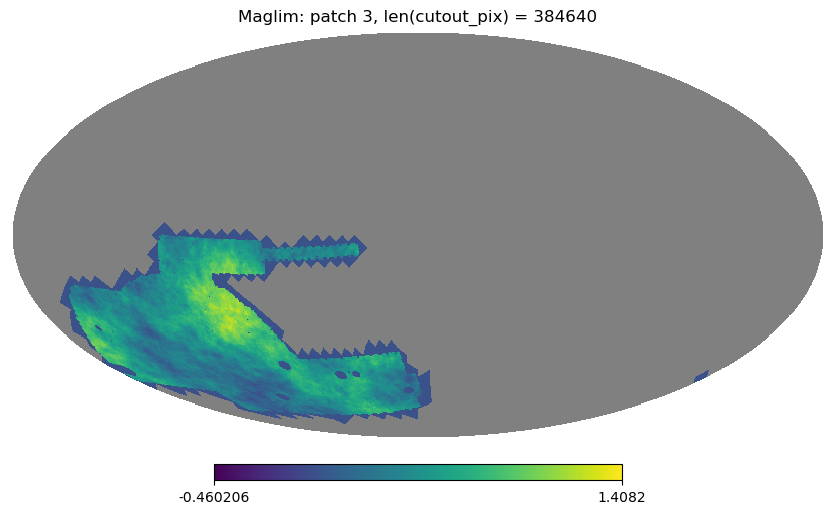

In [ ]:
for patch_id in range(4):
    # Metacal
    for z_id, z_bin in zip(range(4), conf["survey"]["metacal"]["z_bins"]):
        cutout_pix = metacal_tomo_patches_pix[z_id][patch_id]
        corresponding_pix = metacal_tomo_corresponding_pix[z_id]

        data_vec = map_to_data_vec(example_map, len(data_vec_pix), corresponding_pix, cutout_pix)

        m_plot = np.full(n_pix, hp.UNSEEN)
        m_plot[data_vec_pix] = data_vec
        hp.mollview(m_plot, min=z_min, max=z_max, title=f"Metacal: bin {z_bin}, patch {patch_id}, len(cutout_pix) = {len(cutout_pix)}", nest=True)

    # Maglim
    cutout_pix = maglim_patches_pix[patch_id]
    corresponding_pix = maglim_corresponding_pix

    data_vec = map_to_data_vec(example_map, len(data_vec_pix), corresponding_pix, cutout_pix)

    m_plot = np.full(n_pix, hp.UNSEEN)
    m_plot[data_vec_pix] = data_vec
    hp.mollview(m_plot, min=z_min, max=z_max, title=f"Maglim: patch {patch_id}, len(cutout_pix) = {len(cutout_pix)}", nest=True)